# **8-applied-statistics. Lab 1.1**

Михайло Корешков  
Валентина Сириця  
ФІ-91  


In [2]:
import numpy as np
import scipy as sp
import math

import sympy

import matplotlib.pyplot as plt
import time

## Завдання 2.
Обчислити  
$\displaystyle Q_m = P(\eta > \xi_1 + ... + \xi_m)$

$\xi_i - i.i.d.$, $\eta, \xi_i$ - незалежні

$P(\eta < x) = G(x) = \mathbb{1}(x \ge 0) \left(1 - \frac{1}{1+x}\right)$  
$P(\xi_i < x) = F(x) = \mathbb{1}(x \ge 0) \left( 1-e^{-x} \right)$

Тобто $\xi_i \sim Exp(1)$.

Let $\zeta = \xi_1 + ... + \xi_m$.  
$A_m(x) = P(\zeta < x) = \sum_{k=m}^\infty \frac{x^k}{k!}e^{-x} \quad (x \ge 0)$

$\zeta \sim Erlang(m, 1)$

$a_m(x) = \frac{x^{m-1}}{(m-1)!}e^{-x}$

---

В результаті маємо 

$Q_m = P(\eta > \zeta) = \int_{y=0}^\infty \int_{x=y}^\infty \rho_\eta(x) f_\zeta(y) dx dy = \int_{x=0}^\infty (1-G(x)) \cdot \frac{x^{m-1}}{(m-1)!}e^{-x} dx$

$Q_m = \int_{x=0}^\infty \frac{1}{1+x} \cdot \frac{x^{m-1}}{(m-1)!}e^{-x} dx$

### 0. Теоретичне значення інтеграла

In [10]:
def calculate_theor(m):
    result = sympy.integrate((1/(1+u))*(u**(m-1)/(sympy.factorial(m-1)))*sympy.exp(-u), (u, 0, sympy.oo))
    val = result.evalf()
    print(f"The result of the integral (m={m}) is: {result} = {val}")
    return val

true_q = dict()
m = 1
u = sympy.Symbol('u')
for i in range(5):
    true_q[m] = calculate_theor(m)
    m *= 10

The result of the integral (m=1) is: E*expint(1, 1) = 0.596347362323194
The result of the integral (m=10) is: E*expint(10, 1) = 0.0989291326406462
The result of the integral (m=100) is: E*expint(100, 1) = 0.00999899020908473
The result of the integral (m=1000) is: E*expint(1000, 1) = 0.000999998999002009
The result of the integral (m=10000) is: E*expint(10000, 1) = 0.0000999999989999000


Перевірка генерації випадкових значень

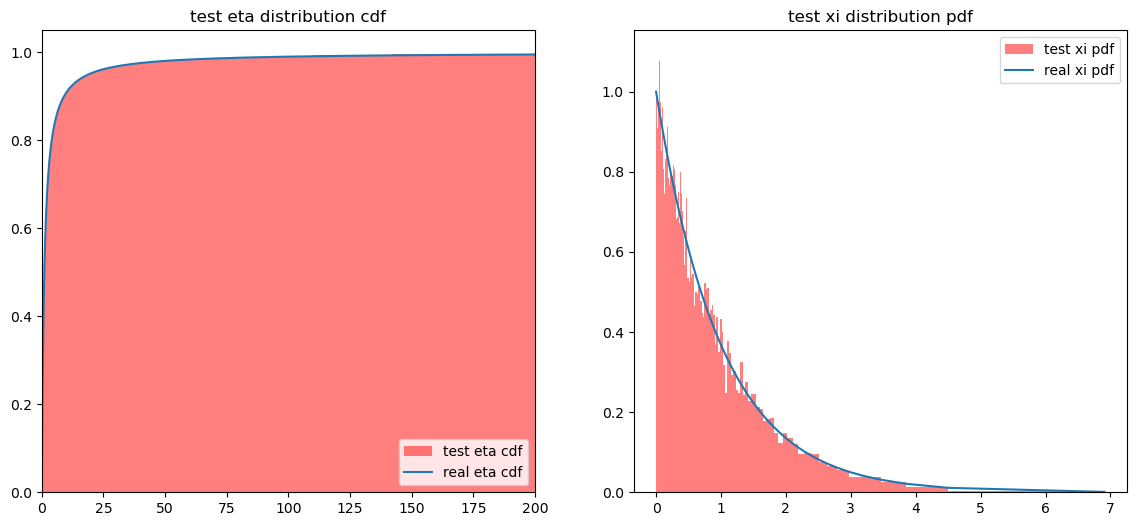

In [11]:
# m - кількість \xi в кожному наборі, N - кількість наборів (\eta, \vec \xi)
# returns eta(N), xi(m,N)
def generate(m, N):
    eta = 1/np.random.rand(N) - 1
    xi = -np.log(np.random.rand(m, N))
    return eta, xi

test_eta, test_xi = generate(1,10000)

fig, axs = plt.subplots(1,2)
bins_eta = 1/(1-np.linspace(0,0.999,1000)) - 1
axs[0].hist(test_eta, bins=bins_eta, label='test eta cdf', color='r', alpha=0.5, density=True, cumulative=True)
axs[0].plot(bins_eta, 1-1/(1+bins_eta), label='real eta cdf')
axs[0].set_xlim((0, 200))
axs[0].legend()
axs[0].set_title("test eta distribution cdf")

bins_xi = -np.log(1-np.linspace(0,0.999,100))
axs[1].hist(test_xi.T, bins=bins_xi, label='test xi pdf', color='r', alpha=0.5, density=True)
axs[1].plot(bins_xi, np.exp(-bins_xi), label='real xi pdf')
axs[1].set_title("test xi distribution pdf")
axs[1].legend()
# fig.legend()
fig.set_size_inches((14,6))

### Кількість реалізацій

In [12]:
def is_precise(Q_rvs, n0=2, z=2.575, eps=0.01):
    n = Q_rvs.shape[0]
    ref = (z*z) / (eps*eps)
    ratio = np.square(Q_rvs.mean()) / Q_rvs.var(ddof=1)
    val = n * ratio
    return (n >= n0) and ( val > ref ), val, ref, ratio

def is_precise_iter(n, mean, var, n0=1, z=2.575, eps=0.01):
    ref = (z*z) / (eps*eps)
    ratio = np.square(mean) / var
    val = n * ratio
    return (n >= n0) and ( val > ref ), val, ref, ratio

### Метод 1
Звичайний Монте-Карло.

Генеруємо багато вибірок виду $(\eta^i, \xi_1^i, ..., \xi_m^i)$.  
$Q_m = M \mathbf 1 (\eta > \xi_1 + ... + \xi_m) \approx mean(\mathbf 1 (\eta^i > \xi^i_1 + ... + \xi^i_m)) $

In [13]:
def mc1(m, N):
    eta, xis = generate(m, N)
    q_rvs = eta > xis.sum(axis=0)
    print(f'eta:{eta.shape}, xis:{xis.shape}, q:{q_rvs.shape}')

    prec = is_precise(q_rvs)
    if prec[0]:
        print(f"mc1(m={m}, N={N}) - OK, precise enough ({prec[1]:.3f} > {prec[2]:.3f}, r={prec[3]:.3f})")
    else:
        print(f"mc1(m={m}, N={N}) - FAILED, not precise ({prec[1]:.3f} < {prec[2]:.3f}, r={prec[3]:.3f})")

    Q = q_rvs.mean()
    print(f'> Mean q(m={m}) = {Q}')
    print(f'> Variance of q = {q_rvs.var()}')
    error = (Q - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')
    return Q

In [14]:
def mc1_iter(m, N, batch_size=1000):
    
    n_epochs = int(N / batch_size)
    N0 = n_epochs * batch_size
    N_left = N

    q_all = np.array([], np.float64)

    epoch_counter = 1
    t0 = time.time()
    t1 = None
    while N_left > 0:
        t0_b = time.time()
        N_local = min(batch_size, N_left)
        eta, xis = generate(m, N_local)
        q_all = np.append(q_all, eta > xis.sum(axis=0)) # \hat q_i defined here
        t1 = time.time()
        
        N_left -= N_local
        print(f'batch {epoch_counter}/{n_epochs} : {N_left} left (took {(t1-t0_b)})')
        epoch_counter += 1
        
    print(f"total phase 1 time = {t1-t0}")
    print(f"starting phase 2")

    t0 = time.time()
    Q_mean = q_all.mean()
    Q_var = q_all.var(ddof=1)

    print(f"total phase2 time = {time.time() - t0}")

    prec = is_precise_iter(N, Q_mean, Q_var)
    if prec[0]:
        print(f"mc1_iter(m={m}, N={N}) - OK, precise enough ({prec[1]:.3f} > {prec[2]:.3f}, r={prec[3]})")
    else:
        print(f"mc1_iter(m={m}, N={N}) - FAILED, not precise ({prec[1]:.3f} < {prec[2]:.3f}, r={prec[3]})")

    print(f'> Mean q(m={m}) = {Q_mean}')
    print(f'> Variance of q = {Q_var}')
    error = (Q_mean - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')


In [15]:
mc1(1, 50_000)

eta:(50000,), xis:(1, 50000), q:(50000,)
mc1(m=1, N=50000) - OK, precise enough (73816.066 > 66306.250, r=1.476)
> Mean q(m=1) = 0.59618
> Variance of q = 0.24074940760000002
> error = -0.00017 (-0.000%)


0.59618

In [16]:
mc1(10, 700_000)

eta:(700000,), xis:(10, 700000), q:(700000,)
mc1(m=10, N=700000) - OK, precise enough (76732.162 > 66306.250, r=0.110)
> Mean q(m=10) = 0.09878857142857143
> Variance of q = 0.08902938958367351
> error = -0.00014 (-0.001%)


0.09878857142857143

In [17]:
mc1(100, 6_000_000)

eta:(6000000,), xis:(100, 6000000), q:(6000000,)
mc1(m=100, N=6000000) - FAILED, not precise (60556.056 < 66306.250, r=0.010)
> Mean q(m=100) = 0.009991833333333333
> Variance of q = 0.00989199659997225
> error = -0.00001 (-0.001%)


0.009991833333333333

In [129]:
mc1(100, 7_000_000)

eta:(7000000,), xis:(100, 7000000), q:(7000000,)
mc1(m=100, N=7000000) - OK, precise enough (70672.370 > 66306.250, r=0.010)
> Mean q = 0.009995142857142857
> Variance of q = 0.009895239976408154


0.009995142857142857

In [146]:
mc1_iter(1000, 10_000_000, batch_size=100_000)

batch 1/100 : 9900000 left (took 4.85208535194397)
batch 2/100 : 9800000 left (took 5.788457632064819)
batch 3/100 : 9700000 left (took 5.77520751953125)
batch 4/100 : 9600000 left (took 6.352574110031128)
batch 5/100 : 9500000 left (took 5.507274627685547)
batch 6/100 : 9400000 left (took 5.651612043380737)
batch 7/100 : 9300000 left (took 5.709232568740845)
batch 8/100 : 9200000 left (took 5.376727342605591)
batch 9/100 : 9100000 left (took 5.622347354888916)
batch 10/100 : 9000000 left (took 5.4856109619140625)
batch 11/100 : 8900000 left (took 5.346362590789795)
batch 12/100 : 8800000 left (took 5.673114061355591)
batch 13/100 : 8700000 left (took 5.89569354057312)
batch 14/100 : 8600000 left (took 5.542424917221069)
batch 15/100 : 8500000 left (took 5.492339372634888)
batch 16/100 : 8400000 left (took 5.437991619110107)
batch 17/100 : 8300000 left (took 5.313339948654175)
batch 18/100 : 8200000 left (took 5.354003429412842)
batch 19/100 : 8100000 left (took 5.599145412445068)
batc

### Метод 2

$\hat q_i = \frac{1}{1 + \xi^{(i)}_1 + ... + \xi^{(i)}_n}$


In [18]:
def mc2_iter(m, N, batch_size=1000):
    
    n_epochs = int(N / batch_size)
    N0 = n_epochs * batch_size
    N_left = N

    q_all = np.array([], np.float64)

    epoch_counter = 1
    t0 = time.time()
    t1 = None
    while N_left > 0:
        t0_b = time.time()
        N_local = min(batch_size, N_left)
        eta, xis = generate(m, N_local)
        q_all = np.append(q_all, (1 / (1 + xis.sum(axis=0))) ) # \hat q_i defined here
        t1 = time.time()
        
        N_left -= N_local
        print(f'batch {epoch_counter}/{n_epochs} : {N_left} left (took {(t1-t0_b)})')
        epoch_counter += 1
        
    print(f"total phase 1 time = {t1-t0}")
    print(f"starting phase 2")

    t0 = time.time()
    Q_mean = q_all.mean()
    Q_var = q_all.var(ddof=1)

    print(f"total phase2 time = {time.time() - t0}")

    prec = is_precise_iter(N, Q_mean, Q_var)
    if prec[0]:
        print(f"mc2_iter(m={m}, N={N}) - OK, precise enough ({prec[1]:.3f} > {prec[2]:.3f}, r={prec[3]})")
    else:
        print(f"mc2_iter(m={m}, N={N}) - FAILED, not precise ({prec[1]:.3f} < {prec[2]:.3f}, r={prec[3]})")

    print(f'> Mean q(m={m}) = {Q_mean}')
    print(f'> Variance of q(m={m}) = {Q_var}')
    error = (Q_mean - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')


In [19]:
mc2_iter(m=1, N=10_000)

batch 1/10 : 9000 left (took 0.0049893856048583984)
batch 2/10 : 8000 left (took 0.0009946823120117188)
batch 3/10 : 7000 left (took 0.0)
batch 4/10 : 6000 left (took 0.0)
batch 5/10 : 5000 left (took 0.0010068416595458984)
batch 6/10 : 4000 left (took 0.0)
batch 7/10 : 3000 left (took 0.0)
batch 8/10 : 2000 left (took 0.0)
batch 9/10 : 1000 left (took 0.0)
batch 10/10 : 0 left (took 0.0)
total phase 1 time = 0.008001327514648438
starting phase 2
total phase2 time = 0.0009894371032714844
mc2_iter(m=1, N=10000) - OK, precise enough (73818.401 > 66306.250, r=7.381840084316154)
> Mean q(m=1) = 0.5946223047483421
> Variance of q(m=1) = 0.04789804185211974
> error = -0.00173 (-0.003%)


In [20]:
mc2_iter(m=10, N=8_000)

batch 1/8 : 7000 left (took 0.001020193099975586)
batch 2/8 : 6000 left (took 0.0)
batch 3/8 : 5000 left (took 0.0010018348693847656)
batch 4/8 : 4000 left (took 0.0)
batch 5/8 : 3000 left (took 0.0)
batch 6/8 : 2000 left (took 0.0)
batch 7/8 : 1000 left (took 0.00101470947265625)
batch 8/8 : 0 left (took 0.0)
total phase 1 time = 0.004019498825073242
starting phase 2
total phase2 time = 0.000990152359008789
mc2_iter(m=10, N=8000) - OK, precise enough (83952.149 > 66306.250, r=10.494018664342226)
> Mean q(m=10) = 0.09881318705721215
> Variance of q(m=10) = 0.0009304391624136315
> error = -0.00012 (-0.001%)


In [21]:
mc2_iter(m=100, N=800)

batch 1/0 : 0 left (took 0.0020055770874023438)
total phase 1 time = 0.0020055770874023438
starting phase 2
total phase2 time = 0.000997781753540039
mc2_iter(m=100, N=800) - OK, precise enough (85808.242 > 66306.250, r=107.26030211388161)
> Mean q(m=100) = 0.010028113309931365
> Variance of q(m=100) = 9.375608177017036e-07
> error = 0.00003 (0.003%)


In [22]:
mc2_iter(m=1000, N=80)

batch 1/0 : 0 left (took 0.003983497619628906)
total phase 1 time = 0.003983497619628906
starting phase 2
total phase2 time = 0.0
mc2_iter(m=1000, N=80) - FAILED, not precise (65074.966 < 66306.250, r=813.4370774853539)
> Mean q(m=1000) = 0.001007553238370629
> Variance of q(m=1000) = 1.2479926920584953e-09
> error = 0.00001 (0.008%)


### Метод 3

$\displaystyle \hat q_i = \frac{1}{m-1} \cdot \frac{n \overline{\xi^{(i)}}}{1 + n \overline{\xi^{(i)}}}$

In [23]:
def mc3_iter(m, N, batch_size=1000):
    
    n_epochs = int(N / batch_size)
    N0 = n_epochs * batch_size
    N_left = N

    q_all = np.array([], np.float64)

    epoch_counter = 1
    t0 = time.time()
    t1 = None
    while N_left > 0:
        t0_b = time.time()
        N_local = min(batch_size, N_left)
        eta, xis = generate(m, N_local)
        xi_sum = xis.sum(axis=0)
        q_all = np.append(q_all, xi_sum / ((m - 1) * (1 + xi_sum)) )  # \hat q_i defined here
        t1 = time.time()
        
        N_left -= N_local
        print(f'batch {epoch_counter}/{n_epochs} : {N_left} left (took {(t1-t0_b)})')
        epoch_counter += 1
        
    print(f"total phase 1 time = {t1-t0}")
    print(f"starting phase 2")

    t0 = time.time()
    Q_mean = q_all.mean()
    Q_var = q_all.var(ddof=1) if (N > 1) else q_all.var()

    print(f"total phase2 time = {time.time() - t0}")

    prec = is_precise_iter(N, Q_mean, Q_var)
    if prec[0]:
        print(f"mc3_iter(m={m}, N={N}) - OK, precise enough ({prec[1]:.3f} > {prec[2]:.3f}, r={prec[3]})")
    else:
        print(f"mc3_iter(m={m}, N={N}) - FAILED, not precise ({prec[1]:.3f} < {prec[2]:.3f}, r={prec[3]})")

    print(f'> Mean q(m={m}) = {Q_mean}')
    print(f'> Variance of q(m={m}) = {Q_var}')
    error = (Q_mean - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')


In [24]:
mc3_iter(m=10, N=100)

batch 1/0 : 0 left (took 0.0009975433349609375)
total phase 1 time = 0.0009975433349609375
starting phase 2
total phase2 time = 0.001003265380859375
mc3_iter(m=10, N=100) - OK, precise enough (95813.023 > 66306.250, r=958.1302280909583)
> Mean q(m=10) = 0.10046672433266161
> Variance of q(m=10) = 1.0534645919945662e-05
> error = 0.00154 (0.016%)


In [25]:
mc3_iter(m=100, N=2)

batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
total phase2 time = 0.0
mc3_iter(m=100, N=2) - OK, precise enough (2609949.780 > 66306.250, r=1304974.8900845603)
> Mean q(m=100) = 0.009996455711824268
> Variance of q(m=100) = 7.657551693733263e-11
> error = -0.00000 (-0.000%)


In [26]:
mc3_iter(m=100, N=1)

batch 1/0 : 0 left (took 0.0009992122650146484)
total phase 1 time = 0.0009992122650146484
starting phase 2
total phase2 time = 0.0
mc3_iter(m=100, N=1) - OK, precise enough (inf > 66306.250, r=inf)
> Mean q(m=100) = 0.009990418617966875
> Variance of q(m=100) = 0.0
> error = -0.00001 (-0.001%)


C:\Users\mkrooted\AppData\Local\Temp\ipykernel_7812\502964565.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = np.square(mean) / var


In [27]:
mc3_iter(m=1000, N=2)

batch 1/0 : 0 left (took 0.002024412155151367)
total phase 1 time = 0.002024412155151367
starting phase 2
total phase2 time = 0.0009860992431640625
mc3_iter(m=1000, N=2) - OK, precise enough (12454809944.357 > 66306.250, r=6227404972.178539)
> Mean q(m=1000) = 0.000999987556499862
> Variance of q(m=1000) = 1.6057653510925311e-16
> error = -0.00000 (-0.000%)


In [28]:
mc3_iter(m=1000, N=1)

batch 1/0 : 0 left (took 0.001003265380859375)
total phase 1 time = 0.001003265380859375
starting phase 2
total phase2 time = 0.0
mc3_iter(m=1000, N=1) - OK, precise enough (inf > 66306.250, r=inf)
> Mean q(m=1000) = 0.000999994662557168
> Variance of q(m=1000) = 0.0
> error = -0.00000 (-0.000%)


C:\Users\mkrooted\AppData\Local\Temp\ipykernel_7812\502964565.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = np.square(mean) / var
